# Introduction

The following study seeks to uncover and help detect manipulation in the financial markets, although it is focused on forex the logic applies to any market. For this we will explore three statistical methodologies combined with the use of algorithms, and typical formulas in machine learning.

Another very important topic to deal with is the understanding of the different types of brokers that exist and for this we will explore the data they offer us, so we will be able to make a data analysis with which to check how biased they can be and see their differences, asymmetry, outliers, among others...

The use of Exploratory data analysis and the subsequent use of an algorithm I created called "Price synchronization algorithm" will help us to detect similarities (if any) between groups of brokers and thus try to deduce if they have liquidity providers in common.
Finally I offer an algorithm that simulates a totally artificial market, and which can be configured with volatility and spread parameters to create the most realistic scenario possible, with it we will test all the techniques learned and see if they are really useful for such cases in the real world, we will end with a satisfactory conclusion about the power of combining several methods of detection of manipulation and never be guided by a single technique. With this we can also train our machine learning and deep learning algorithms by copying features of real markets and simulating them to study their behavior, this applies to FOREX, Futures, Binary Options, Cryptos ... and an endless number of markets.

---

Topics to be treated:
* Types of brokers
* Preparing the for metatrader 5 platform
* EDA - Exploratory data analysis on brokers
* First method for market manipulation: Pearson's correlation matrix.
* Second method: MSE, RMSE
* Third method: ANOVA for delta price distributions, Logarithmic transform, Shapiro, Levene and Bartlett test.
* Price synchronization algorithm
* Dukascopy for historical FOREX data.
* Random walk, Stochastic processes and Price generator algorithm: Designing an artificial market as a Market Maker.


# Libraries needed

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Types of brokers

Before we get into the statistical tools and algorithms to use there is something we must understand, in the FOREX market there are two different kinds of brokers, let's call them: *market makers* and *liquidity providers*. We will see an outline of this followed by an explanation.

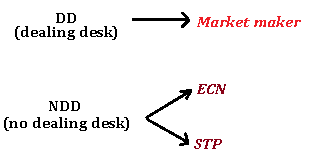

Both market makers and ECN/STP are part of two different categories, this is fundamental because if we want to understand these complex markets our analysis must start from this fact.
Based on this we will be able to justify the so repeated term "manipulation" and what it refers to, therefore when we study the significance (statistically speaking) between markets of different brokers we will be able to discriminate correctly in which market we are and what will be its degree of manipulation.

**Dealing desk**


These are the market making brokers, i.e. they set the conditions of price, spreads, commissions, etc... this does not always mean that they literally design a market but one thing is true, their business model is "zero sum" (i.e. for one to win the other has to lose). So instead of delving into the technicalities of how they do it we will summarize this in separate classes.
 * *Orders that do not go to market*: This is the typical case, as we know FOREX is comprised of an interbank market, that is a conglomerate of investment funds and high level banks that provide us with the information of the quotations, therefore when we open a position what we would naturally expect is that it is sent directly to one of the above mentioned. In reality this never happens, since the order remains inside the broker's own order book (hence the name dealing desk) in other words they have a digital list of all market participants and although the market charts are real, they control you and the positions. I will leave to the reader's imagination the damage this may cause to each participant's capital...
 * *Market against you*: This market is an individual trap, I say this because although the chart may look very similar to the original one, the small changes (or big changes depending on the occasion) that they make in the Bid and Ask can end up with your trade in losses. There are algorithms capable of doing this; based on the size of your account and exposure on the order, the calculations will tell you what this price difference should be with the real one, thus ending your position in losses, i.e. the currency pair you analyze will be different for each market participant. Resulting in a personalized study for each case that can determine the difference between the broker's price and the real one, as it is logical, this type of market and the previous one are the most complicated to detect if algorithmic, mathematical and statistical methods are not used.  Of course always supporting this in a previous analysis of the market (even making use of artificial intelligence) and fundamentals according to the occasion.
 * *Artificial market*: Another blatant lie, there is not much to say since in the worst case the correlation of this market will be null compared to its real counterpart. This market is by nature against you, plus the orders you place will always be manipulated to make you believe the false illusion that you can win, this never works out. As in the first case, the orders never go to market because after all, the broker is your counterparty.

**No Dealing Desk**

This type of brokers send the orders or positions of the participants directly to the market, there are two types of NDD:
  * *STP(Straight Through Processing)*: These brokers send the operations of their clients directly to their liquidity providers (examples of them are; JP Morgan, HSBC, Goldman Sachs, among others...), the mechanism by which they benefit is the following: their system looks at every moment their different liquidity providers guaranteeing the best possible Bid and Ask, then this is sent to the operator (that is the one who opened an order or position in the market) adding a spread of a certain amount, thus resulting in the profit and business of the broker. Theoretically it is said that this type of brokers do not have conflicts of interest with their clients, however there are occasions where open positions do not find a counterparty and they intervene by hedging the position as their counterparty.
  * *ECN(Electronic Communications Network)*: They send transactions directly to the interbank market (like STP), i.e. to their liquidity providers, their business model or profit mechanism is the same as in the case of STP. The difference between this type of brokers is that they have a greater number of suppliers and clients and therefore offer a greater depth of market (access to level II or order book), however we must remember that the FOREX market is non-centralized and as a result of this we will only get the order book of the liquidity of these suppliers and not of the entire market(as happens for example with stocks or futures), i.e we only access to a part of the market for more suppliers available the broker have.

This is a brief synthesis of the types of brokers and their so-called business model, although in reality there are tactics within the legal framework that allow them to profit even more. As in the case of those who even being an NDD use companies with apparent different names (but in reality they are themselves) to be the counterpart of their clients or the use of complex algorithms to detect which of them should be controlled, manipulating in any way the price of their suppliers, however minimal it may be, therefore the manipulation is not necessarily to completely change the market scheme.
In the next section we will look at some methods and algorithms to detect this behavior as far as possible and see what we can conclude from this.

#Preparing the code for metatrader 5

The first step will be to write the necessary code to 'record' the prices of the different brokerage houses in a given time frame, the analysis of this we will see in detail later, for now it is enough to compile without any error this code in the scripting system included in metatrader 5, to do this we must create a new script with the name "mql5_python_prices_backtester", once done this will create a new tab with code, and on it we replace all the existing code with the one below

To generate the data we will use the option in the MT5 for indicators (once compiled), we choose in the menu the one with the name we create.
In options date range to analyze will be from 2015-1-1 to 2020-12-30, the currency pair is left to choice, however for this analysis we used the GBP-USD and the timeframe will be 1 day candles. After this we click on run and it will write the data in a ".csv" file with the names of the analyzed currency pair and the time frame in which it was done(which corresponds to the data mentioned above).

```
//+------------------------------------------------------------------+
//| Proyect: mql5_python_prices_backtester.mqh                       |
//| Author: Gabriel Zenobi                                           |
//| Date: 17/07/2020                                                 |
//+------------------------------------------------------------------+
#property indicator_chart_window

#include <arrays/arrayobj.mqh>
#include <arrays/arraystring.mqh>
#include <arrays/arraydouble.mqh>
#include <object.mqh>

// ----------------------------------------------------------------------------------------------
// ---------------------------------------- CBarsCounter ----------------------------------------
class CBarsCounter
{
private:
   ulong    m_bars;
   datetime m_prev_time;
public:
  CBarsCounter(ulong init_count = 0) : m_bars(init_count) {}
  ~CBarsCounter(){}
   
  virtual bool OnTick(void);
  void ResetCounter(int bars = 0){
    this.m_bars = bars;
  }
  ulong GetBars() const{
    return this.m_bars;
  }
};

bool CBarsCounter::OnTick(void)
{
   datetime curr_time = iTime(_Symbol, _Period, 0);
   if(curr_time == this.m_prev_time) {
      return false;
   }
   this.m_prev_time= curr_time;
   this.m_bars++;

   return true;
}
// ----------------------------------------------------------------------------------------------

CBarsCounter barsCounter; 
CArrayString BarsDate;
CArrayDouble BarsOpen;
CArrayDouble BarsHigh;
CArrayDouble BarsLow;
CArrayDouble BarsClose;

// 1 periodo o barra en el pasado
int m_bar_shift = 1;
string from_datetime = "";

string GetCurrentYMD(string delim="-")
{
  MqlDateTime curr_dt;
  TimeCurrent(curr_dt);
  
  return IntegerToString(curr_dt.year)+delim+IntegerToString(curr_dt.mon)+delim+IntegerToString(curr_dt.day);
}

string GetTimeframeString()
{
  switch(Period())
  {
    case PERIOD_M1:{ return "M1"; }
    case PERIOD_M5:{ return "M5"; }
    case PERIOD_M10:{ return "M10"; }
    case PERIOD_M15:{ return "M15"; }
    case PERIOD_M30:{ return "M30"; }
    case PERIOD_H1:{ return "H1"; }
    case PERIOD_H4:{ return "H4"; }
    case PERIOD_D1:{ return "D1"; }
    
    default: return "";
  }
}

int OnInit()
{
  from_datetime= GetCurrentYMD();
  
  return INIT_SUCCEEDED;
}

void OnTick()
{
  // !- al crearse una nueva barra
  if( barsCounter.OnTick() )
  {
    datetime time  = iTime(Symbol() , Period(), m_bar_shift);
    double   open  = iOpen(Symbol() , Period(), m_bar_shift); 
    double   high  = iHigh(Symbol() , Period(), m_bar_shift); 
    double   low   = iLow(Symbol()  , Period(), m_bar_shift); 
    double   close = iClose(Symbol(), Period(), m_bar_shift); 
    
    BarsDate.Add(TimeToString(time));
    BarsOpen.Add(open);
    BarsHigh.Add(high);
    BarsLow.Add(low);
    BarsClose.Add(close);
  }
}

bool save_prices_to_csv(string from_datetime, string& filename_generated)
{
  filename_generated = _Symbol+"-"+from_datetime+"-"+GetCurrentYMD()+"-"+GetTimeframeString()+".csv";
  int file = FileOpen(filename_generated, FILE_WRITE|FILE_CSV, ',', CP_UTF8);
  if( file == INVALID_HANDLE )
    return false;
    
  FileWrite(file, "Date", "Open", "High", "Low", "Close");
  
  int total_bars = (int)barsCounter.GetBars();
  // la primera linea no nos aporta ninguna informacion real
  for(int i = 1; i < total_bars; i++){
    FileWrite(file, BarsDate.At(i), BarsOpen.At(i), BarsHigh.At(i), BarsLow.At(i), BarsClose.At(i));//, MathRound((open - close)/_Point));
  }
  
  return true;
}

void OnDeinit(const int reason)
{
  string filename;
  if( save_prices_to_csv(from_datetime, filename) ){
    Print("[*] File '", filename, "' saved!");
  }
  else{
    Print("[-] Error to save '",filename,"'");
  }
}
```

# EDA - Exploratory data analysis on brokers

The data used are from ECN/STP type brokers, so the following analysis will exclude completely the *Market Makers* as these are the most obvious cases where the market has no point of comparison due to the degree of manipulation(partial or total in the worst case).

In [39]:
def load_brokers_prices(labels):
  brokers = {}
  for k,v in labels.items():
    brokers[k] = pd.read_csv(v)
  return brokers

labels = {'MetaQuotes':'datasets/MetaQuotes-GBPUSD-2015-1-1-2020-12-30-D1.csv',
          'HotForex':'datasets/HotForex-GBPUSD-2015-1-1-2020-12-30-D1.csv',
          'IFCMarkets':'datasets/IFCMarkets-GBPUSD-2015-1-1-2020-12-30-D1.csv',
          'AdmiralMarkets':'datasets/AdmiralMarkets-GBPUSD-2015-1-1-2020-12-30-D1.csv',
          'ICMarkets':'datasets/ICMarkets-GBPUSD-2015-1-1-2020-12-30-D1.csv',
          'Swissquote':'datasets/Swissquote-GBPUSD-2015-1-1-2020-12-30-D1.csv'}

brokers = load_brokers_prices(labels)

In [40]:
def generate_deltas_from_prices(df):#, drop=['Open', 'Low', 'High']):
  def get_candle_type(price):
    if price["Close"] > price["Open"] : return "bullish"
    if price["Close"] < price["Open"] : return "bearish"
    #if price["Close"] == price["Open"] : return "undefined"
    return "undefined"

  def set_candle_type(row):
    type_ = row["Type"]
    if type_ is "bullish":
      return row["Delta"]
    if type_ is "bearish":
      return -row["Delta"]

    return None

  df_p = pd.DataFrame()
  df_p["Date"]  = df["Date"]
  df_p["Delta"] = df["High"] - df["Low"]
  df_p["Type"]  = df.apply(lambda row: get_candle_type(row), axis=1)
  df_p["Delta"] = df_p.apply(lambda row: set_candle_type(row), axis=1)
  df_p["Close"] = df["Close"]
  #if drop is not None:
    #df_p.drop(labels=drop, inplace=True, axis=1)
  df_p.dropna(axis=1)
  return df_p

for k in brokers.keys():
  brokers[k] = generate_deltas_from_prices(brokers[k])

Plot of prices of the different brokerage houses (I separated the most divergent ones in two different charts).

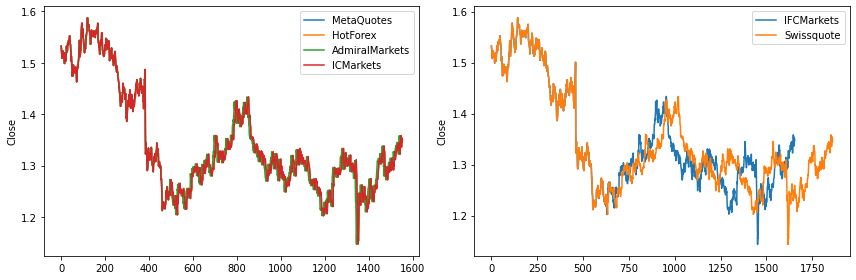

In [41]:
_, axs = plt.subplots(figsize=(12,4), ncols=2)
sns.lineplot(data=brokers['MetaQuotes'], x=brokers['MetaQuotes'].index, y='Close', label='MetaQuotes', ax=axs[0])
sns.lineplot(data=brokers['HotForex'], x=brokers['HotForex'].index, y='Close', label='HotForex', ax=axs[0])
sns.lineplot(data=brokers['AdmiralMarkets'], x=brokers['AdmiralMarkets'].index, y='Close', label='AdmiralMarkets', ax=axs[0])
sns.lineplot(data=brokers['ICMarkets'], x=brokers['ICMarkets'].index, y='Close', label='ICMarkets', ax=axs[0])
sns.lineplot(data=brokers['IFCMarkets'], x=brokers['IFCMarkets'].index, y='Close', label='IFCMarkets', ax=axs[1])
sns.lineplot(data=brokers['Swissquote'], x=brokers['Swissquote'].index, y='Close', label='Swissquote', ax=axs[1])
plt.tight_layout()
plt.show()

As we can see there are discrepancies between the left and right plots, so if we overlap them in a single plot this is what we will see.

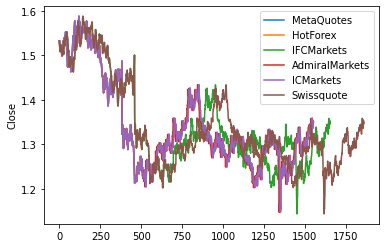

In [42]:
for k, v in brokers.items():
  sns.lineplot(data=v, x=v.index, y='Close', label=k)
plt.show()

This asynchrony of the same market may be due to different causes of the Metatrader 5 platform, the most obvious is perhaps the latency in the packages that bring the price information added to the working days that can be tradable (perhaps there have been blockages on certain days in some brokerage houses and others not). Remember that the charts we see are the result of the data received by the liquidity providers which are not all the same for the different number of existing brokers.

*Delta distribution of the various brokerage firms*

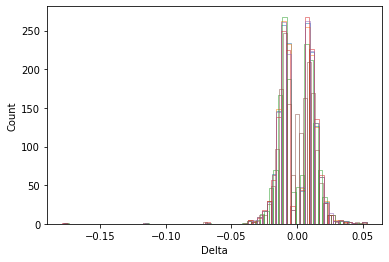

In [43]:
for k, v in brokers.items():
  sns.histplot(v['Delta'], fill=False, label=k)
plt.show()

Asymmetry of distributions

In [44]:
for k, v in brokers.items():
  print(k, v['Delta'].skew())

MetaQuotes -1.5562257440284457
HotForex -1.5546378856566019
IFCMarkets -1.5564330043474601
AdmiralMarkets -1.4399202612056616
ICMarkets -1.581485122686779
Swissquote -1.4541579449049074


Outliers test

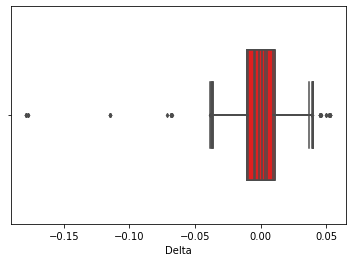

In [45]:
for m in brokers.values():
  sns.boxplot(data=m, x='Delta', color='red', fliersize=3, width=0.6)
plt.show()

**Conclusion**

A brief exploratory data analysis showed us an aspect of the similarity of the markets provided by the different brokers, however there is still some work to be done before we can conclude anything... Because although it is true that there seems to be a degree of parity between the data we do not apply any analytical method that can give us more detailed information about this, in the next sections we will delve into three techniques (simple in my opinion) that are robust enough to detect blatant manipulations in case we are facing totally different markets, and thus conclude that after all, the FOREX despite not having transparency (as in the case of indices and stocks) for being non-centralized, perhaps give us data from the same liquidity providers in common, and understand that there are differences between them, agreements and business models that brokers may anyway manipulate or be their counterpart.

# First method for market manipulation: Pearson's correlation matrix.

This is the simplest method of all so we will use it only in some cases, remember that each candlestick has an OHLC (open-high-low-close) structure and therefore the type of price we take will be the one used for all the markets we analyze. For this case we will use the 'Close' price and compare the markets of the first group (analyzed in the previous section) on the one hand, and those of the second group on the other hand.

To achieve our objective we will make use of Pearson's correlation coefficient which represents the level of linear relationship or dependence between two variables, this can vary between [-1, 1] being 1 the perfect positive correlation (when one variable increases or decreases the other also does so in equal rate), and -1 the perfect negative correlation (when one variable increases the other decreases in equal proportion, this is also known as inverse relationship), on the other hand a value close to 0 means that there is no linear relationship between the variables and therefore their changes will not depend on each other. There is a big assumption about the reliability of this formula in certain situations, since the correlation does not imply causality, i.e. even if this coefficient is close to its ideal value it does not mean that the processes studied have a direct cause-relationship, and conversely if it is 0 (or close to it) this does not imply the independence of the events since after all this coefficient only measures the **linear** relationship between the variables, i.e. there may be non-linear relationships governing the process and therefore this coefficient will not detect this.

However, why use Pearson?, for this case things are much simpler because let's reason the following, we only need to know if when a value increases or decreases the other (of the same market but different broker) also does it, since we are not analyzing the process in terms of cause and effect relationships, we only want to know their similarity so for this case this formula will be enough:

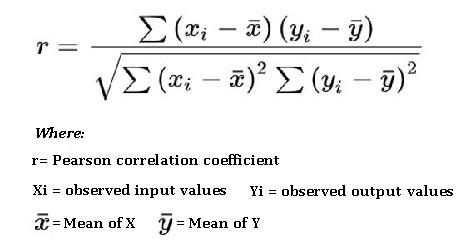

Let's transfer all the prices of the first chart to a first group of brokers.

In [46]:
def get_markets_by_prices(group, price_type='Close'):
  prices = {}
  for g in group:
    prices[g] = brokers[g][price_type]

  return pd.DataFrame(data=prices, columns=group)

group_1 = get_markets_by_prices(['MetaQuotes', 'HotForex', 'AdmiralMarkets', 'ICMarkets'])
group_1.head()

,MetaQuotes,HotForex,AdmiralMarkets,ICMarkets
0,1.53244,1.53244,1.53266,1.53244
1,1.52483,1.52483,1.52501,1.52483
2,1.51485,1.51485,1.51496,1.51485
3,1.51084,1.51084,1.51114,1.51084
4,1.50882,1.50882,1.50894,1.50882


Now we are in position to calculate Pearson's correlation matrix, let's look at this analytically.

In [47]:
group_1.corr()

,MetaQuotes,HotForex,AdmiralMarkets,ICMarkets
MetaQuotes,1.000000,0.999997,0.985668,0.999991
HotForex,0.999997,1.000000,0.985682,0.999992
AdmiralMarkets,0.985668,0.985682,1.000000,0.985657
ICMarkets,0.999991,0.999992,0.985657,1.000000


Let us repeat the process for the second group of brokers.

In [48]:
group_2 = get_markets_by_prices(['IFCMarkets', 'Swissquote'])
group_2.corr()

,IFCMarkets,Swissquote
IFCMarkets,1.000000,0.930862
Swissquote,0.930862,1.000000


Now let's put the two groups together and calculate the total correlation matrix, for this case using the Heatmap function of the Seaborn library we will get a more abstract visual representation of this.

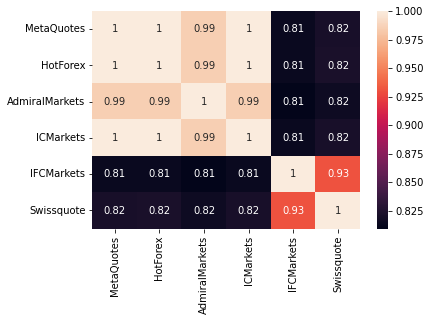

In [49]:
sns.heatmap(data=get_markets_by_prices(['MetaQuotes', 'HotForex', 'AdmiralMarkets', 'ICMarkets', 'IFCMarkets', 'Swissquote']).corr(), annot=True)
plt.show()

As expected the correlation between the first and second group is weaker than the correlation of each pair of brokers between them, if this same formula were used to analyze different types of prices (Open, High and Low) you could see variations in such coefficients but this is an analysis that I will leave to the decision of each one, for now let's continue with the next method.

#Second method - MSE, RMSE

In this second part we will continue with another simple formula that starts from the concept of error, this should not be interpreted as something negative, since with it we will be able to quantify the existing difference in the different markets studied, we will continue with this explanation later on. Let's see the formula:

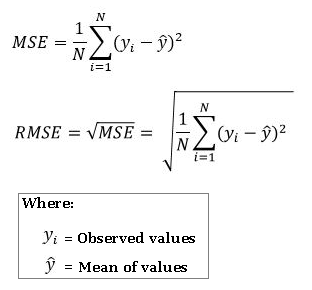

Before generalizing the problem, let's take any two brokers and apply the formula, let's see how much this value is.

In [50]:
error = brokers['MetaQuotes']['Close'] - brokers['HotForex']['Close']
error= error**2
np.sqrt(error.mean())

0.00024436756815401873

What we must understand about this ratio is that the closer it is to zero, the smaller the error will be (and therefore the more similar the markets of the different brokers will be). However, what do we mean by "error"?, it is actually quite simple, the formula measures the distance around the mean of the observations studied on a single axis (let's assume it is the Y-axis), squares it and sums it for each observation in our dataset, then weights it by the total number of observations resulting in the mean of the squared distances calculated. As a final term applies a root which is used due to the fact that when raising and adding values to the square these will result in an extremely large number and therefore perform such operation we would get a much smaller value.

**Generalizing the problem to N markets of different brokers.**

What we are looking for now is to generate an error matrix containing each pair of broker markets, for this we will use the itertools library, with which we will generate all the possible combinations that will be used for the matrix calculations.

In [51]:
from itertools import product

def rmse_matrix(brokers, brokers_labels, price_type):
  brokers_pairs = [item for item in product(brokers_labels, repeat=2)]
  rmse_ = []
  pairs_left = []
  pairs_right= []
  for p in brokers_pairs:
    error = brokers[p[0]][price_type] - brokers[p[1]][price_type]
    error= error**2
    rmse_.append(np.sqrt(error.mean()))
    pairs_left.append(p[0])
    pairs_right.append(p[1])
  return pd.DataFrame(data={'1':pairs_left, '2':pairs_right, 'RMSE':rmse_})

df_error_matrix = rmse_matrix(brokers, ['MetaQuotes', 'HotForex', 'AdmiralMarkets', 'ICMarkets', 'IFCMarkets', 'Swissquote'], 'Close')
df_error_matrix.head()

,1,2,RMSE
0,MetaQuotes,MetaQuotes,0.000000
1,MetaQuotes,HotForex,0.000244
2,MetaQuotes,AdmiralMarkets,0.016953
3,MetaQuotes,ICMarkets,0.000436
4,MetaQuotes,IFCMarkets,0.063614


In order to visualize this correctly in a 2d-matrix we must pivot the pandas data-frame

In [52]:
error_matrix = df_error_matrix.pivot(index='1', columns='2', values='RMSE')
error_matrix 

2,AdmiralMarkets,HotForex,ICMarkets,IFCMarkets,MetaQuotes,Swissquote
1,,,,,,
AdmiralMarkets,0.000000,0.016948,0.016950,0.064431,0.016953,0.063043
HotForex,0.016948,0.000000,0.000426,0.063615,0.000244,0.062145
ICMarkets,0.016950,0.000426,0.000000,0.063612,0.000436,0.062137
IFCMarkets,0.064431,0.063615,0.063612,0.000000,0.063614,0.038359
MetaQuotes,0.016953,0.000244,0.000436,0.063614,0.000000,0.062143
Swissquote,0.063043,0.062145,0.062137,0.038359,0.062143,0.000000


Using the Seaborn heatmap we plot this matrix

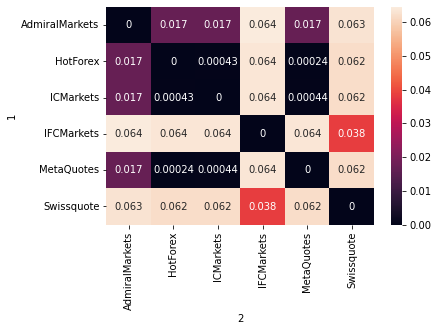

In [53]:
sns.heatmap(data=error_matrix, annot=True)
plt.show()

Let us point out the following characteristics of this matrix:
  * The diagonal of the matrix will always be 0 because the error of a variable compared to itself is zero, i.e. there is no error.
  * The different pairs of brokers show the differences between their markets (for the same currency pair analyzed), as we said, the smaller this value is, the less error the markets will have, i.e. they will be more similar.
  * As in a correlation matrix the values of the sides separating the diagonal are symmetrical.

A very important step that was omitted for testing purposes and that should be taken into account is to normalize the data, since otherwise it would be impossible to determine a level of "confidence" (as in the case of Pearson's coefficient that gives us an interval of strength of the relationship of the variables). That is to say, by not having a minimum and a maximum, there would be no way to determine which is the smallest recommended value and which would be the largest possible error.

#Third method: ANOVA for delta price distributions, Logarithmic transform, Shapiro, Levene and Bartlett test.

The analysis of variance (abbreviated ANOVA) is a statistical method used for the comparison of means from different populations, this is useful in the analysis of experiments in which you try to find out if there are significant differences between them, the most classic example that can be found is in medical studies, in which you want to test if different treatments show significant differences in their results.

For this we make use of the hypothesis contrast which infers the following:
  * Null hypothesis(H0) : All means are equal, we conclude that the results of the N experiments are not considered random.
  * Alternate hypothesis (H1): At least one pair of means has significant differences, there is not enough evidence to prove that the experiment is or is not due to the randomness.

Before taking this to the markets, let's look at a brief summary of the formulas used:

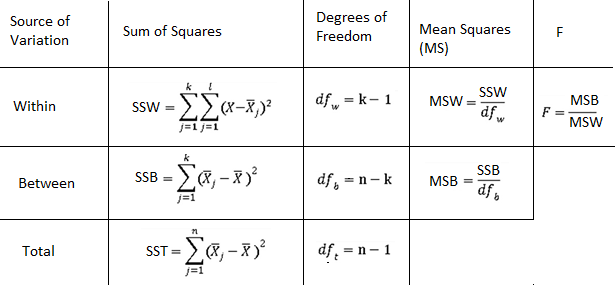

We will not go into detail about each formula (it is not the objective of the problem), it is enough to know that *F* will be the ratio that we must compare with a certain value to know if we accept the hypothesis that all the means of the price distributions of the different brokers are equal or at least a couple of them differ. In addition there are some assumptions that must be satisfied in order to use ANOVA correctly, let's see what they are.
  * Independence of observations.
  * The distribution of the residuals must be normal.
  * Homoscedasticity: homogeneity of variances (population variances are equal).

Therefore, if all these conditions are fulfilled, we can pose the null hypothesis (H0) and the alternative hypothesis (H1) on the means of the different groups or distributions studied.

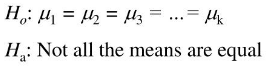

The next step will be to test all this on the markets (before doing the variance analysis), we will use the python libraries.

*We check the normality assumption.*

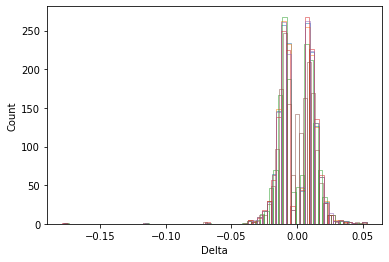

In [54]:
for k, v in brokers.items():
  sns.histplot(v['Delta'], fill=False, label=k)
plt.show()

Although we already did this in the exploratory data analysis section, we will now take care of cleaning the outliers. For this we will use the boxplot graph which shows this in a clearer way.

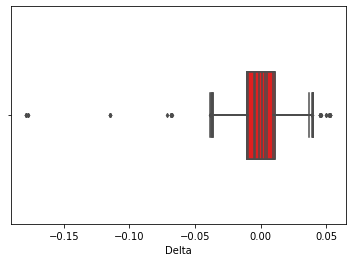

In [55]:
for b in brokers.values():
  sns.boxplot(data=b, x='Delta', color='red', fliersize=3, width=0.4)
plt.show()

As you can see all the distributions accumulate (approximately) in a common zone, the condition used for this case will be.

In [56]:
def clear_outliers(brokers):
  for k, v in brokers.items():
    m= v['Delta']
    brokers[k]= brokers[k][(m>=-0.05) & (m<=0.04)]

clear_outliers(brokers)

*Normality assumption of ANOVA: Delta price distributions.*

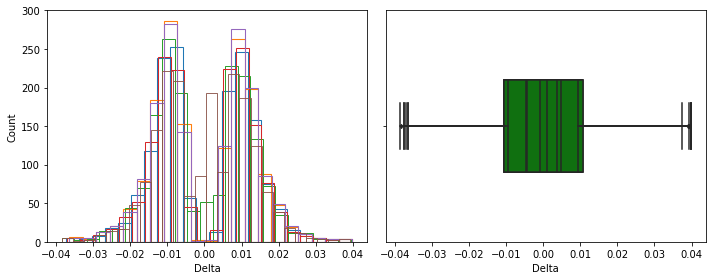

In [57]:
_, axs = plt.subplots(figsize=(10,4), ncols=2)

for k, v in brokers.items():
  sns.histplot(v['Delta'], fill=False, label=k, ax=axs[0])
for b in brokers.values():
  sns.boxplot(data=b, x='Delta', color='green', fliersize=3, width=0.4, ax=axs[1])

plt.tight_layout()
plt.show()

Non-overlapping distributions

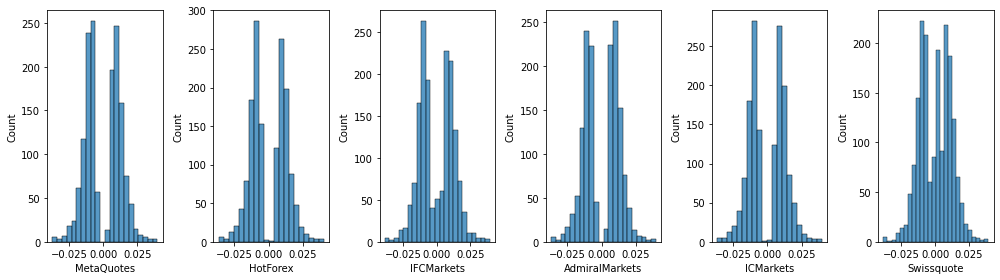

In [58]:
_, axs = plt.subplots(figsize=(14,4), ncols=len(brokers))

i = 0
for k, v in brokers.items():
  axs[i].set_xlabel(k)
  sns.histplot(v['Delta'], fill=True, label=k, ax=axs[i])
  i+= 1
  
plt.tight_layout()
plt.show()

Without outliers we can better appreciate the different distributions (let's not lose sight of the fact that these are the delta of prices of the same currency in the different FOREX brokers), which as we can see are not perfectly normal and in fact the values close to the mean tend to be "cut" in a V-shape.

Although as we said this assumption is important for the ANOVA test, due to its robustness it can be violated because although it is not a normal distribution it is close enough to it (besides we have a lot of data so we gain enough statistical power). If we use the **Shapiro-Wilk** test under these conditions it will fail, therefore at this point we can apply a logarithmic transformation (in base **e**) to each of the distributions.

---

**Logarithmic transform**

Aplicar esta transformacion es util en los casos en los que la distribucion no es normal(o casi-normal), tengamos en cuenta que no siempre corregira la asimetria pero es una gran ayuda que nos puede ganarantizar una "estabilizacion" en las distribuciones que estudiemos.

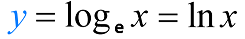

In [59]:
normal_brokers = {}
ln_normal_brokers = {}

for k, v in brokers.items():
  normal_brokers[k] = v['Delta'].dropna()
for k, v in brokers.items():
  ln_normal_brokers[k] = np.log(v['Delta'].dropna())

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


To perform this transformation we use the numpy library, now we can check the normality of the distributions and we will do it for both cases; before the transformation and after it is applied.

In [60]:
from scipy.stats import shapiro

def test_normality(brokers, alpha=0.05):
  for k, m in brokers.items():
    stat, p = shapiro(m)
    print('Market:<{}> statistic={}, p-value={}'.format(k,np.round(stat,4), np.round(p,4)) )
    if p > alpha:
      print('Sample is Gaussian (fail to reject H0)')
    else:
      print('Sample does not look Gaussian (reject H0), H1 accepted')
    print('')

Let's check analytically whether the distributions are normal *before the logarithmic transformation*.

In [61]:
test_normality(normal_brokers)

Market:<MetaQuotes> statistic=0.9481, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<HotForex> statistic=0.9482, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<IFCMarkets> statistic=0.964, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<AdmiralMarkets> statistic=0.9475, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<ICMarkets> statistic=0.9484, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<Swissquote> statistic=0.9826, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted



After applying *logarithmic transformation*.

In [62]:
test_normality(ln_normal_brokers)

Market:<MetaQuotes> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)

Market:<HotForex> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)

Market:<IFCMarkets> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)

Market:<AdmiralMarkets> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)

Market:<ICMarkets> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)

Market:<Swissquote> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)



As we can see after applying the transformation the distribution was normal, from now on we will use it for the next remaining tests.

If we do the plot again we can see this in detail; the cuts around the mean will have disappeared and in general the aspect will look more like a Gaussian distribution, of course not all of them will have the same shape but we will have applied a fundamental correction. Another important feature is that the population means are not centered at the origin (i.e. 0), but shifted to the left with negative values.

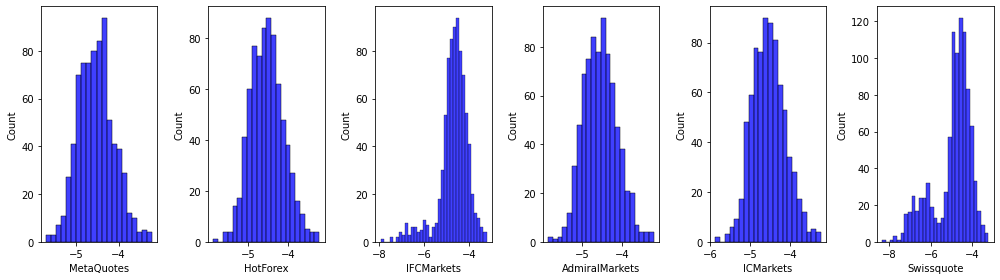

In [63]:
_, axs = plt.subplots(figsize=(14,4), ncols=len(ln_normal_brokers))

i = 0
for k, v in ln_normal_brokers.items():
  axs[i].set_xlabel(k)
  sns.histplot(v, ax=axs[i], color='blue')
  i+= 1
  
plt.tight_layout()
plt.show()

*Homoscedasticity assumption (of variances) of ANOVA.*

To check this assumption we will use Levene's test, which will tell us analytically if the equality of variances is fulfilled (null hypothesis H0) or on the contrary we can reject it and accept the alternative hypothesis H1.

In [64]:
from scipy.stats import levene

stat, p = levene(ln_normal_brokers['MetaQuotes'].dropna(),
                 ln_normal_brokers['HotForex'].dropna(),
                 ln_normal_brokers['IFCMarkets'].dropna(),
                 ln_normal_brokers['AdmiralMarkets'].dropna(),
                 ln_normal_brokers['ICMarkets'].dropna(),
                 ln_normal_brokers['Swissquote'].dropna())
alpha = 0.05
if p > alpha:
	print('Samples have equal variances (fail to reject H0).')
else:
	print('Samples have [NOT] equal variances (reject H0), H1 accepted.')
print("statistic:{}, p-value:{}".format(stat, p))

Samples have [NOT] equal variances (reject H0), H1 accepted.
statistic:96.55299524704999, p-value:2.7472530217783185e-97


Alternatively, we can use Bartlett's test for the same purpose.

In [65]:
from scipy.stats import bartlett

stat, p = bartlett(ln_normal_brokers['MetaQuotes'].dropna(),
                   ln_normal_brokers['HotForex'].dropna(),
                   ln_normal_brokers['IFCMarkets'].dropna(),
                   ln_normal_brokers['AdmiralMarkets'].dropna(),
                   ln_normal_brokers['ICMarkets'].dropna(),
                   ln_normal_brokers['Swissquote'].dropna())
alpha = 0.05
if p > alpha:
	print('Samples have equal variances (fail to reject H0).')
else:
	print('Samples have [NOT] equal variances (reject H0), H1 accepted.')
print("statistic:{}, p-value:{}".format(stat, p))

Samples have [NOT] equal variances (reject H0), H1 accepted.
statistic:1140.5951040140442, p-value:2.1606178716945342e-244


Finally we come to the ANOVA, we should note that the homogeneity assumption was not met and therefore if we continue we will be increasing the error of this test. Alternatively, we can perform a non-parametric test such as the Kruskar-Wallis test, however, what we initially tested has already been demonstrated and is beyond the scope of our analysis.

In [66]:
import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(ln_normal_brokers['MetaQuotes'].dropna(),
                                ln_normal_brokers['HotForex'].dropna(),
                                ln_normal_brokers['IFCMarkets'].dropna(),
                                ln_normal_brokers['AdmiralMarkets'].dropna(),
                                ln_normal_brokers['ICMarkets'].dropna(),
                                ln_normal_brokers['Swissquote'].dropna())
alpha = 0.05
if p > alpha:
	print('Samples have equal means(fail to reject H0).')
else:
	print('Samples have [NOT] equal means(reject H0), H1 accepted.')
print("statistic:{}, p-value:{}".format(stat, p))

Samples have [NOT] equal means(reject H0), H1 accepted.
statistic:1140.5951040140442, p-value:2.1606178716945342e-244


As an additional step we can do the same procedure for those distributions more similar to the normal one, according to the transform graphs, these are: MetaQuotes, HotForex, AdmiralMarkets and ICMarkets.

In [67]:
alpha = 0.05
stat, p = bartlett(ln_normal_brokers['MetaQuotes'].dropna(),
                   ln_normal_brokers['HotForex'].dropna(),
                   ln_normal_brokers['AdmiralMarkets'].dropna(),
                   ln_normal_brokers['ICMarkets'].dropna())
if p > alpha: print('Samples have equal variances (fail to reject H0).')
else: print('Samples have [NOT] equal variances (reject H0), H1 accepted.')
print("p-value:{}".format(p))

fvalue, pvalue = stats.f_oneway(ln_normal_brokers['MetaQuotes'].dropna(),
                                ln_normal_brokers['HotForex'].dropna(),
                                ln_normal_brokers['AdmiralMarkets'].dropna(),
                                ln_normal_brokers['ICMarkets'].dropna())
if p > alpha: print('Means are equal(fail to reject H0), perhaps the data comes from the same liquidity providers.')
else: print('Mean are [NOT] equal, H1 accepted(reject H0). Perhaps the data not comes from the same liquidity providers.')
print("p-value:{}".format(p))

Samples have equal variances (fail to reject H0).
p-value:0.9935373091045707
Means are equal(fail to reject H0), perhaps the data comes from the same liquidity providers.
p-value:0.9935373091045707


As we can see in this case, the population means coincide, so the assumption of equality of liquidity providers is satisfied.

#Price synchronization algorithm

As we saw the prices are not synchronized in date order, this means that some days appear in certain markets and in others not... Therefore we need a data ordering mechanism (due to causes such as latency or slipage), so in that way this problem is not an impediment to correctly analyze broker prices.

The following algorithm is an idea I had based on the coordination of dates, this means that prices will only be registered if the dates match, otherwise they will be rejected. So we can compare prices on the same time scale even if some days were tradable and others not (such as holidays and catastrophic events), so the following function takes a broker as a reference point and compares it with the dates of the others, filtering the information that is not in temporal order to generate pairs of markets around that point. This mechanism although it is useful has a problem, the loss of information is inevitable, because there will be dates "lost" or not found and this is what we must take into account whenever we run it in an analysis, it is also an extremely expensive algorithm in computational terms (we will not analyze this or optimize it because it is not the purpose of this article).

In [84]:
brokers['IFCMarkets'].head()

,Date,Delta,Type,Close
0,2015.01.02 00:00,-0.02225,bearish,1.53244
1,2015.01.04 00:00,-0.01303,bearish,1.52684
2,2015.01.05 00:00,-0.01160,bearish,1.52510
3,2015.01.06 00:00,-0.01650,bearish,1.51380
4,2015.01.07 00:00,-0.01003,bearish,1.51049


In [124]:
from datetime import datetime

def sync_prices_by_date(dict_dfs:dict, df_ref_name:str, df_to_compare_names:list, date_column_name:str='Date', price_type:str='Close', df_ref_time_format:str='%Y.%m.%d', dfs_time_format:str='%Y.%m.%d')->dict:
  def compare_prices_by_date(dict_dfs:dict, df_ref_name:str, df_to_compare_name:list, date_column_name='Date', price_type='Close', df_ref_time_format='%Y.%m.%d', dfs_time_format='%Y.%m.%d'):
    df_ref = dict_dfs[df_ref_name]
    df_comp= dict_dfs[df_to_compare_name]
    l1 = len(df_ref[date_column_name])
    l2 = len(df_comp[date_column_name])
    b1 = []
    b2 = []

    for i in range(l1):
      if i not in df_ref.index:
        continue
      
      d1 = df_ref[date_column_name][i]
      dmy1 = d1[:d1.index(' ')]
      for j in range(l2):
        if j not in df_comp.index:
          continue
        d2 = df_comp[date_column_name][j]
        dmy2 = d2[:d2.index(' ')]

        if datetime.strptime(dmy1, df_ref_time_format).date() == datetime.strptime(dmy2, dfs_time_format).date():
          b1.append(df_ref[price_type][i])
          b2.append(df_comp[price_type][j])
          break
    
    return pd.DataFrame(data={df_ref_name:b1, df_to_compare_name:b2})

  dicts_df = {}
  for n in df_to_compare_names:
    dicts_df[df_ref_name+'-'+n] = compare_prices_by_date(dict_dfs, df_ref_name, n, date_column_name, price_type, df_ref_time_format, dfs_time_format)
  
  return dicts_df

We call the function and compare, in this first example all brokers with respect to our main 'benchmark' is MetaQuotes. Remember that they have on their test server historical data on various currency pairs and other financial instruments, and although this information is biased (as it is probably not exactly the same as that handled by ECN/STP brokers) we can find similarities, and as said for this example is sufficient.

In [125]:
df = sync_prices_by_date(brokers, 'MetaQuotes', ['HotForex', 'IFCMarkets', 'AdmiralMarkets', 'ICMarkets', 'Swissquote'])

It is time to check the same procedure as in the exploratory analysis section, overlapping the markets of the different brokers to get a visual idea of their similarity.

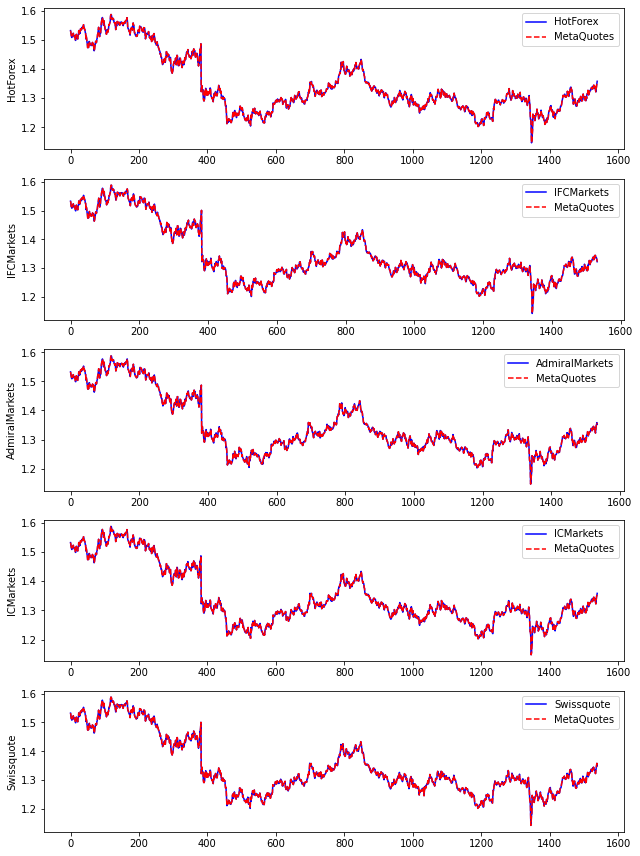

In [126]:
_, axs = plt.subplots(figsize=(9,12), nrows=len(df))
i = 0
m = ['HotForex', 'IFCMarkets', 'AdmiralMarkets', 'ICMarkets', 'Swissquote']
for k, v in df.items():
  sns.lineplot(data=v, x=v.index, y=m[i], label=m[i], ax=axs[i], color='blue')
  sns.lineplot(data=v, x=v.index, y=m[i], label='MetaQuotes', ax=axs[i], linestyle="dashed", color='red')
  i+= 1
plt.tight_layout()
plt.show()

This is a huge improvement... now let's check the correlation matrix (using Pearson).

In [127]:
for v in df.values():
  print(v.corr())
  print("")

            MetaQuotes  HotForex
MetaQuotes    1.000000  0.999997
HotForex      0.999997  1.000000

            MetaQuotes  IFCMarkets
MetaQuotes    1.000000    0.999924
IFCMarkets    0.999924    1.000000

                MetaQuotes  AdmiralMarkets
MetaQuotes        1.000000        0.999991
AdmiralMarkets    0.999991        1.000000

            MetaQuotes  ICMarkets
MetaQuotes    1.000000   0.999993
ICMarkets     0.999993   1.000000

            MetaQuotes  Swissquote
MetaQuotes     1.00000     0.99993
Swissquote     0.99993     1.00000



Let us use the RMSE method for the same purpose.

In [129]:
from itertools import product

def rmse_matrix(df_brokers):
  brokers_pairs = [item for item in product(df_brokers.columns, repeat=2)]
  rmse_ = []
  pairs_left = []
  pairs_right= []
  for p in brokers_pairs:
    error = df_brokers[p[0]] - df_brokers[p[1]]
    error= error**2
    rmse_.append(np.sqrt(error.mean()))
    pairs_left.append(p[0])
    pairs_right.append(p[1])
  df_error_matrix = pd.DataFrame(data={'index':pairs_left, 'column':pairs_right, 'RMSE':rmse_})
  return df_error_matrix.pivot(index='index', columns='column', values='RMSE')

err_matrix = []
for v in df.values():
  print(rmse_matrix(v))
  err_matrix.append(rmse_matrix(v))
  print("")

column      HotForex  MetaQuotes
index                           
HotForex    0.000000    0.000227
MetaQuotes  0.000227    0.000000

column      IFCMarkets  MetaQuotes
index                             
IFCMarkets    0.000000    0.001236
MetaQuotes    0.001236    0.000000

column          AdmiralMarkets  MetaQuotes
index                                     
AdmiralMarkets        0.000000    0.000449
MetaQuotes            0.000449    0.000000

column      ICMarkets  MetaQuotes
index                            
ICMarkets    0.000000    0.000382
MetaQuotes   0.000382    0.000000

column      MetaQuotes  Swissquote
index                             
MetaQuotes    0.000000    0.001185
Swissquote    0.001185    0.000000



Visualizing the matrix in the Seaborn heatmap.

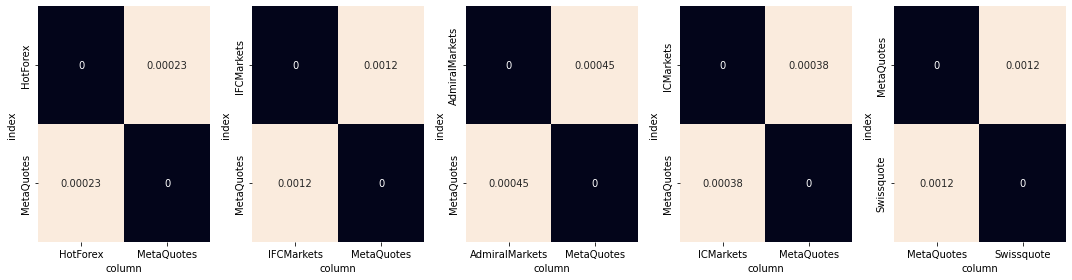

In [130]:
l = len(err_matrix)
_, axs = plt.subplots(figsize=(15,4), ncols=l)
for i in range(l):
  sns.heatmap(err_matrix[i], annot=True, cbar=False, ax=axs[i])
plt.tight_layout()
plt.show()

**Conclusion**

Using this algorithm we were able to clean those inaccuracies resulting from the mechanisms executed by the market itself, thus for the list of brokers studied so far we were able to verify that if we ignore this, their similarities increase. That is, if the world were ideal and there were no delays in the information, perhaps we would see a low level of disparity in the data, but one thing is a post-hoc analysis (or as I like to call it, "forensic analysis") and quite another is in real time, where other calculations add to the complexity of the market, for example some of these are; slipage, computational cost of algorithms, delay of information due to the different providers that the broker uses, among others...

#Dukascopy for historical FOREX data.

So far we only check prices of different brokers among themselves, i.e. we start from the following assumption; brokers give their clients the markets coming from the same liquidity providers (and their partners) or they don't, and create their own data. However, how can we trust that all the charts we are seeing are legitimate?, it would be conspiratorial to believe that everything is an agreement between them, wouldn't it?. The alternative to this is to obtain historical currency data from banks and/or hedge funds and use the same analysis, it seems logical but analyzing this is fundamental because despite the obvious discrepancies that we will find, the fact of consulting liquidity providers will allow us to verify the prices that we see in the graphs, of course it must be noted that being a non-centralized market the differences we find may be significant (as they probably do not use algorithms to choose the best Bid/Ask of their partners or their own currencies) but at one point should coincide with what we have seen before. On the other hand, in a "market maker" broker these differences would be total...

The data compared below come from the Swiss bank Dukascopy, these are free and can be obtained very easily (unlike FXCM or OANDA that have their own REST APIS for this task), personally is where I trust the most and therefore we will use them as a reference point in our algorithm of *synchronized prices*, also applying the methods seen above to detect the differences between the different brokers.

In [131]:
df_dukascopy = pd.read_csv('datasets/DUKASCOPY_GBPUSD_Candlestick_1_D_BID_01.01.2015-31.12.2020.csv')
df_dukascopy.head()

,Local time,Open,High,Low,Close,Volume
0,01.01.2015 19:00:00.000 GMT-0300,1.55783,1.55871,1.53252,1.53252,214767.0782
1,02.01.2015 19:00:00.000 GMT-0300,1.53252,1.53252,1.53252,1.53252,0.0000
2,03.01.2015 19:00:00.000 GMT-0300,1.53252,1.53252,1.53252,1.53252,0.0000
3,04.01.2015 19:00:00.000 GMT-0300,1.53002,1.53193,1.51535,1.52472,210874.6717
4,05.01.2015 19:00:00.000 GMT-0300,1.52474,1.52739,1.51408,1.51502,215543.1504


We change the name of the date column (Local time) to match the name of the dates in the brokers (this is essential for the algorithm to work).

In [132]:
df_dukascopy.rename({'Local time':'Date'}, inplace=True, axis=1)

Although Dukascopy is NOT a broker itself(and this termination may be confusing) we assign it to our already created variable, it will be used by our algorithm otherwise we would have to pass two Data-frames.

In [133]:
brokers['Dukascopy'] = df_dukascopy

Now we are able to call the price synchronization algorithm, with the difference that the date parameter will be inverted, this is due to the way Dukascopy stores the dates of the prices in its database (that is why this algorithm was designed to support such a possible change in the date format). We will also use it as a reference point to analyze all the brokers studied so far.

In [134]:
brokers_labels = ['MetaQuotes', 'HotForex', 'IFCMarkets', 'AdmiralMarkets', 'ICMarkets', 'Swissquote']
df_markets = sync_prices_by_date(brokers, 'Dukascopy', brokers_labels, date_column_name='Date', price_type='Close', df_ref_time_format='%d.%m.%Y', dfs_time_format='%Y.%m.%d')

Let's make a plot of the brokers markets

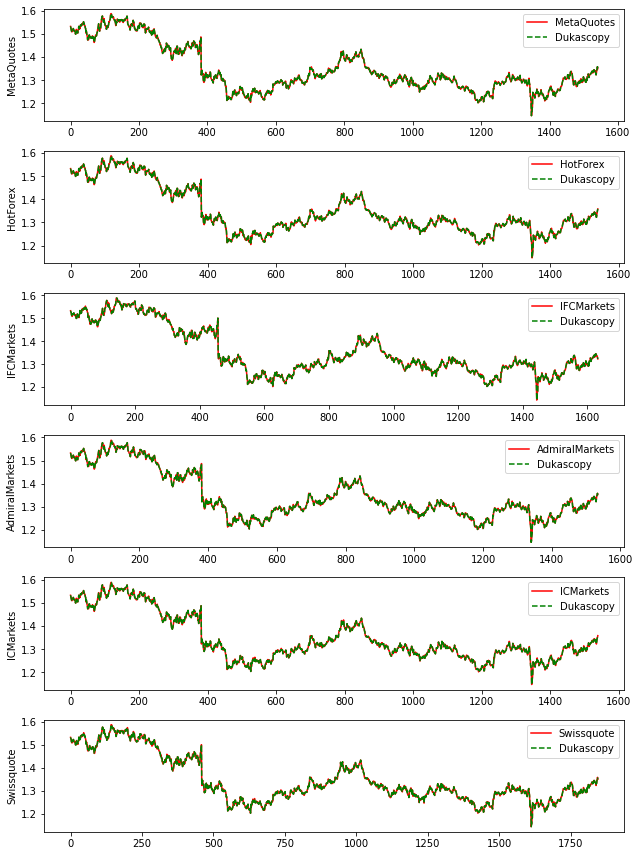

In [135]:
_, axs = plt.subplots(figsize=(9,12), nrows=len(df_markets))
i = 0
m = ['MetaQuotes', 'HotForex', 'IFCMarkets', 'AdmiralMarkets', 'ICMarkets', 'Swissquote']
for k, v in df_markets.items():
  sns.lineplot(data=v, x=v.index, y=m[i], label=m[i], ax=axs[i], color='red')
  sns.lineplot(data=v, x=v.index, y=m[i], label='Dukascopy', ax=axs[i], linestyle="dashed", color='green')
  i+= 1
plt.tight_layout()
plt.show()

**Correlation matrix**

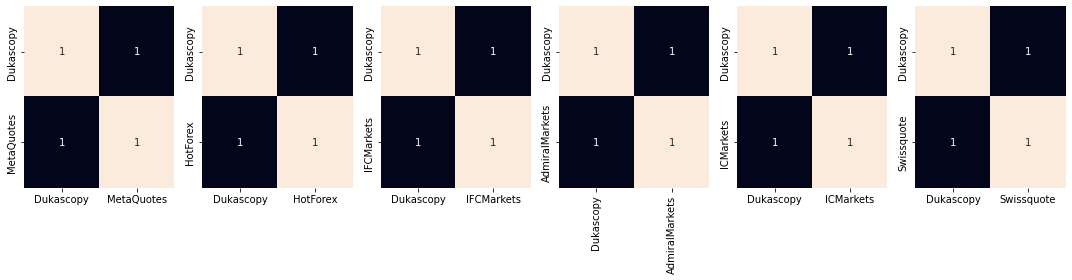

In [136]:
_, axs = plt.subplots(figsize=(15,4), ncols=len(df_markets))
i = 0
for v in df_markets.values():
  sns.heatmap(v.corr(), annot=True, cbar=False, ax=axs[i])
  i+= 1
plt.tight_layout()
plt.show()

That is, after synchronizing the data we see that the correlation is perfect. This is a good sign, since we can see that the markets have the same direction in common. In the first instance it means that according to Pearson's coefficient we can rely to some extent on the market flow, since we must remember that we take Dukascopy as a reference point.

**RMSE matrix**

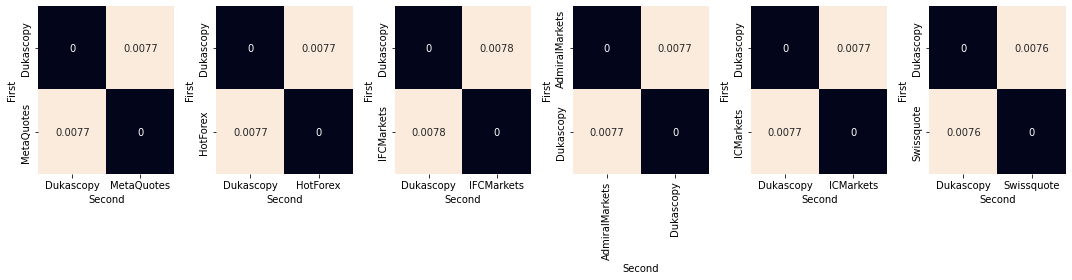

In [137]:
from itertools import product

def rmse_matrix(df_brokers):
  brokers_pairs = [item for item in product(df_brokers.columns, repeat=2)]
  rmse_ = []
  pairs_left = []
  pairs_right= []
  for p in brokers_pairs:
    error = df_brokers[p[0]] - df_brokers[p[1]]
    error= error**2
    rmse_.append(np.sqrt(error.mean()))
    pairs_left.append(p[0])
    pairs_right.append(p[1])
  df_error_matrix = pd.DataFrame(data={'First':pairs_left, 'Second':pairs_right, 'RMSE':rmse_})
  return df_error_matrix.pivot(index='First', columns='Second', values='RMSE')

_, axs = plt.subplots(figsize=(15,4), ncols=len(df_markets))
i = 0
for v in df_markets.values():
  sns.heatmap(rmse_matrix(v), annot=True, cbar=False, ax=axs[i])
  i+= 1
plt.tight_layout()
plt.show()

The error obtained is small which means that the differences between the markets of the different brokers are reliable according to Dukascopy. Another important thing to remember is that for this test the data was not normalized, however for the study done it is sufficient (for a more detailed study this should be checked).

#Random walk, Stochastic processes and Price generator algorithm: Designing an artificial market as a Market Maker.

In previous chapters we emphasized the consequences of artificial markets, in the first instance this would be relatively easy to detect using the right mathematical tools and algorithms, and to support all this with an analysis of the financial instrument in question. Secondly and not less important, the use of a reliable source of data can help to reveal the most fraudulent market movements, however, what happens when the market is totally artificial, this is an interesting question and with the use of probabilistic programming we will find out the result of such a problem.

Let's start with some mathematical formalisms to follow them with an explanation, we will now define a *random walk*.

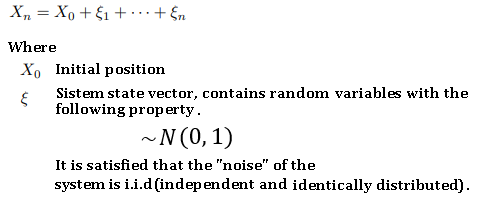

With this in mind we can already assume how our price generating algorithm will be, it will take values from a standard normal distribution to create prices in that range, and since the volatility (or standard deviation) is bounded at 1 the noise generated in our stochastic series will represent a market in that interval, so we need to resort to one more definition.

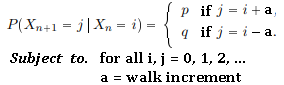

That is, we will depend on an "alpha" which will determine the increase in the price level, as a consequence of which the change of state will be a continuous value drawn from a standard normal distribution, and therefore it will lie in an interval of [-1, +1]. On the other hand, since it is a random walk in 2d and with only 2 possible directions(up or down), we can simplify our model to one of a dichotomous nature (i.e. a binomial distribution to be more technical) so that the probability to which we give more weight will be the one to which the market tends to go, in other words:
  * If p > q, then the market will be bullish.
  * If p < q, then the market will be bearish.
  * If p = q, then the market will be sideways, this is the symmetric case where the probability is like in a coin toss experiment.

Although this theory is much broader and is used to describe and model markets we will not go into it, after all we should not lose sight of the fact that the objective is to develop an algorithm capable of simulating a market where we are able to test the reliability of our data, and with this knowledge we have enough to start developing it. Before moving on to the programming I have to remind you that this test is possible thanks to the *memorylessness* of the markets, this is well known in the study of *stochastic processes* thanks to the Markov property with which, we can justify the creation of our algorithm and the behavior of the markets in general. Let's move on to the code.

In [138]:
def random_walk(size, prob_move_up=0.5, volatility=1, start=1):
  p = prob_move_up
  q = 1 - p
  prob = [q, p]

  positions = [None for _ in range(size)]
  noise     = [None for _ in range(size)]
  positions[0] = noise[0] = start

  for i in range(1, size):
    r = np.random.random(1)[0]
    # nos aseguramos que siempre sea positivo
    step = np.abs(np.random.normal(0, volatility, 1)[0])# / size
    # si la probabilidad dada es que el valor suba
    if r < prob[1]:
      dir= +step
    else:
      dir= -step

    positions[i]= positions[i-1] + dir
    noise[i] = step
  return positions, noise

The probability parameter for this example will be 55% upside, i.e. the market will move 5% of the time in favor of buying generating a long-term uptrend. The market size will be the same as the amount of Dukascopy data available.

Another thing I want to highlight is the parameter **volatility**, as we see this is the one that generates the range of the price increase coming from a normal distribution, so we can make a more realistic comparison of the currency markets to study (whatever they are). This parameter can also be interpreted as the "pips" (in the context of the FOREX market), i.e. the base increment of each currency pair, and while this will not be exact (since in reality the deviation represents how much the values are dispersed around the mean) we can ensure an artificial range of increments for the market to be simulated or copied.

In [139]:
np.random.seed(6)
size = df_dukascopy.shape[0]
index = np.arange(size)
rw_price, rw_noise = random_walk(size, prob_move_up=0.55, volatility=0.001, start=1.5)

**Plot of the artificial market**

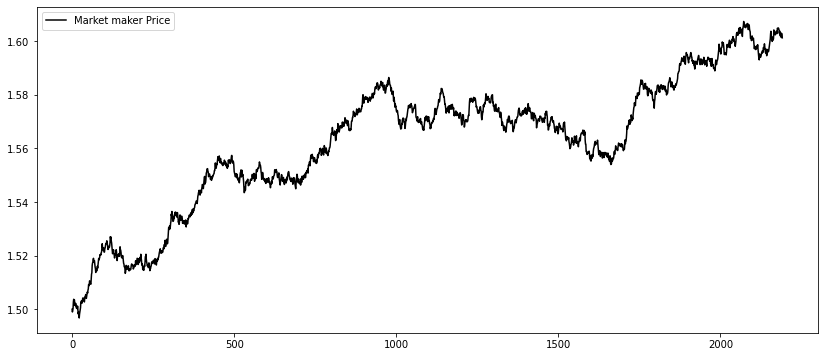

In [140]:
plt.subplots(figsize=(14, 6))
sns.lineplot(x=index, y=rw_price, label='Market maker Price', color='black')
plt.show()

Let's make another plot to see the amount of noise in the system, we can see that it is Gaussian N(0, 1) and stationary (it has no trend component). So we have fulfilled the key assumptions that we needed for such a stochastic process...

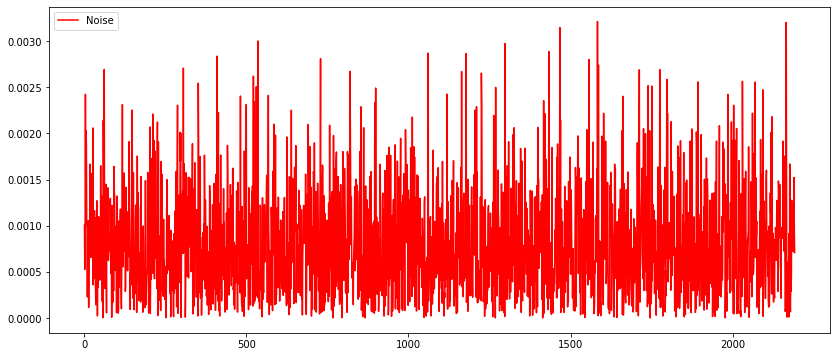

In [141]:
plt.subplots(figsize=(14, 6))
sns.lineplot(x=index[1:], y=rw_noise[1:], label='Noise', color='r')
plt.show()

To finish our analysis let's check the methods studied in the previous sections. First let's put the closing prices of the markets to be compared in a data-frame.

In [142]:
df_brokers = pd.DataFrame()
df_brokers['MarketMaker'] = rw_price
df_brokers['Dukascopy'] = df_dukascopy['Close']

**Pearson matrix**

In [143]:
df_brokers.corr()

,MarketMaker,Dukascopy
MarketMaker,1.00000,-0.72213
Dukascopy,-0.72213,1.00000


The high negative correlation indicates that the directions are opposite, i.e. as one goes up the other goes down and vice versa. On the other hand it is also remarkable how the high value (beyond the sign) of the correlation indicates a relationship in the behavior of both markets, this shows experimentally that even with this method we do not fully capture the market manipulation and need more analysis.

**RMSE** - Root mean square error

In [144]:
from itertools import product

def rmse_matrix(df_brokers):
  brokers_pairs = [item for item in product(df_brokers.columns, repeat=2)]
  rmse_ = []
  pairs_left = []
  pairs_right= []
  for p in brokers_pairs:
    error = df_brokers[p[0]] - df_brokers[p[1]]
    error= error**2
    rmse_.append(np.sqrt(error.mean()))
    pairs_left.append(p[0])
    pairs_right.append(p[1])
  df_error_matrix = pd.DataFrame(data={'First':pairs_left, 'Second':pairs_right, 'RMSE':rmse_})
  return df_error_matrix.pivot(index='First', columns='Second', values='RMSE')

rmse_matrix(df_brokers)

Second,Dukascopy,MarketMaker
First,,
Dukascopy,0.000000,0.248568
MarketMaker,0.248568,0.000000


As expected we have a larger error(not normalized) that explains the difference between price levels compared, this was logical since the price increase generated by our algorithm was intentionally set to a larger unit(although with some similarity) to demonstrate this. In other words, with this method and the previous one, we have a much more robust analysis that can even be used to study and compare markets that are not equal in scale but in correlation.

**Delta distributions.**

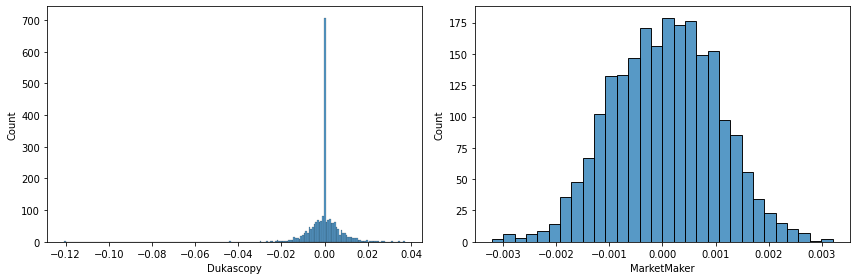

In [145]:
_, axs = plt.subplots(figsize=(12, 4), ncols=2)
sns.histplot(df_brokers['Dukascopy'].diff(), ax=axs[0])
sns.histplot(df_brokers['MarketMaker'].diff(), ax=axs[1])
plt.tight_layout()
plt.show()

As we can see, the Dukascopy distribution is skewed in the tails by the presence of outliers and values near the mean that are highly repeated.

If we eliminate the outliers, we can better see the excessive increase of values around the mean.

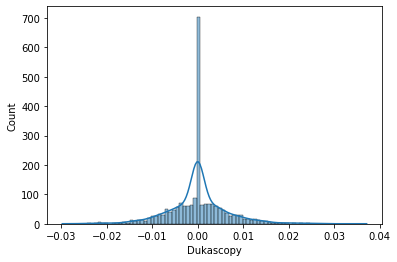

In [146]:
dukascopy_diff = df_brokers['Dukascopy'].diff()
marketmaker_diff = df_brokers['MarketMaker'].diff()

dukascopy_diff = dukascopy_diff[(dukascopy_diff > -0.04) & (dukascopy_diff < 0.04)]
sns.histplot(dukascopy_diff, kde=True)
plt.show()

Let us test the equality of the distributions by performing Student's t-test. This test is the same as ANOVA but for the case where there are only two populations.

In [147]:
from scipy.stats import shapiro
from scipy.stats import bartlett
import scipy.stats as stats

def is_normal(brokers, alpha=0.05):
  err_lvl = 0
  for k, m in brokers.items():
    stat, p = shapiro(m)
    print('Market:<{}> statistic={}, p-value={}'.format(k,np.round(stat,4), np.round(p,4)) )
    if p > alpha:
      print('Sample is Gaussian (fail to reject H0)')
      err_lvl+= 1
    else:
      print('Sample does not look Gaussian (reject H0), H1 accepted')
    print('')
  return err_lvl == len(brokers)

def equal_pair_variances(broker_1, broker_2, alpha = 0.05):
  stat, p = bartlett(broker_1, broker_2)
  is_equal = False
  if p > alpha:
    print('Samples have equal variances (fail to reject H0).')
    is_equal = True
  else:
    print('Samples have [NOT] equal variances (reject H0), H1 accepted.')
  print("statistic:{}, p-value:{}".format(stat, p))
  print('')
  return is_equal

def t_test(broker_1, broker_2, equal_var=True, alpha = 0.05):
  fvalue, p = stats.ttest_ind(broker_1, broker_2, equal_var=equal_var)
  is_equal = False
  if p > alpha:
    print('Samples have equal means(fail to reject H0).')
    is_equal = True
  else:
    print('Samples have [NOT] equal means(reject H0), H1 accepted.')
  print("statistic:{}, p-value:{}".format(fvalue, p))
  return is_equal

Now let's compare Dukascopy with our artificial market.

In [148]:
def test_brokers(name1,broker1, name2,broker2):
  broker1 = broker1.dropna()
  broker2 = broker2.dropna()
  normality = is_normal({name1:broker1, name2:broker2})
  if normality == False or normality == True:
    equal_var = equal_pair_variances(broker1, broker2)
    return t_test(broker1, broker2, equal_var=equal_var)

print("[output]:",test_brokers('Dukascopy',dukascopy_diff, 'MarketMaker',marketmaker_diff) )

Market:<Dukascopy> statistic=0.929, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<MarketMaker> statistic=0.9986, p-value=0.0686
Sample is Gaussian (fail to reject H0)

Samples have [NOT] equal variances (reject H0), H1 accepted.
statistic:5300.5874730672085, p-value:0.0

Samples have equal means(fail to reject H0).
statistic:-0.1919301204371403, p-value:0.8478139712892554
[output]: True


**Conclusion.**

This is truly amazing, because it means that the artificial market that we create and know to be false passes as positive in our stock average test. As stated at the beginning, there is no perfect method and we demonstrate that we must subject brokers markets to several tests and methods, as only one of them is not robust enough to determine the final verdict.

If only the RMSE and the T-test were used, the conclusion would have been very different; the market could be real since the difference in spreads between them, although different, could keep a benefit of the doubt. However, when combining these three methods (even if one of them fails) the Pearson's coefficient matrix shows a suspicious or clear contrary intention between apparently equal markets, coupled with the error provided by the RMSE coefficient, the judgment is clear: the market is the product of a market maker and therefore a blatant scam.